In [193]:
from jmd_imagescraper.core import * # dont't worry, it's designed to work with import *
from pathlib import Path
NUM_CLUSTERS = 4
import numpy as np
import scipy
from scipy import cluster
from wordfreq import top_n_list
from PIL import Image
import requests
from io import BytesIO
import binascii
import json
from tqdm import tqdm
import time
import argparse
from colorthief import ColorThief
import random


def duckduckgo_search_urls(keywords, max_results=10, 
                           img_size: ImgSize=ImgSize.Cached,
                           img_type: ImgType=ImgType.Photo,
                           img_layout: ImgLayout=ImgLayout.All,
                           img_color: ImgColor=ImgColor.All,):
    return duckduckgo_scrape_urls(keywords,max_results,img_size,img_type,img_layout,img_color)

def median_centroid(ar,NUM_CLUSTERS=4):
    codes, dist = cluster.vq.kmeans(ar, NUM_CLUSTERS)
    vecs, dist = cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    # index_max = np.argmax(counts)                    # find most frequent
    
    second_idx,first_idx = np.argsort(counts)[-2:]
    second_color,first_color = codes[second_idx],codes[first_idx]
    second_sta,first_sta = rgb_to_saturation(second_color),rgb_to_saturation(first_color)
    if second_sta>first_sta:
        return second_color
    else:
        return first_color
    
def rgb_to_saturation(ar): 
    # R, G, B values are divided by 255 
    # to change the range from 0..255 to 0..1: 
    r, g, b =ar 
  
    # h, s, v = hue, saturation, value 
    cmax = max(r, g, b)    # maximum of r, g, b 
    cmin = min(r, g, b)    # minimum of r, g, b 
    diff = cmax-cmin       # diff of cmax and cmin. 
  
    # if cmax and cmax are equal then h = 0 
    if cmax == cmin:  
        h = 0
      
    # if cmax equal r then compute h 
    elif cmax == r:  
        h = (60 * ((g - b) / diff) + 360) % 360
  
    # if cmax equal g then compute h 
    elif cmax == g: 
        h = (60 * ((b - r) / diff) + 120) % 360
  
    # if cmax equal b then compute h 
    elif cmax == b: 
        h = (60 * ((r - g) / diff) + 240) % 360
  
    # if cmax equal zero 
    if cmax == 0: 
        s = 0
    else: 
        s = (diff / cmax) * 100
  
    # compute v 
    v = cmax * 100
#     return h, s, v
    return s

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def word_to_color(word):
    links = duckduckgo_search_urls(word)
    colors = []
    for link in links:
        try:
            response = requests.get(link)
            im = Image.open(BytesIO(response.content))

            im = im.convert('RGB')
            im = im.resize((100, 100))
            ar = np.array(im)
            shape = ar.shape
            ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)
            peak = median_centroid(ar,NUM_CLUSTERS=5)

            colors.append(peak)
        except:
            pass
#     md = median_centroid(np.array(list(colors)).astype(float),NUM_CLUSTERS=3)
    md = median_centroid(np.array(colors),NUM_CLUSTERS=3)
    color = binascii.hexlify(bytearray(int(c) for c in md)).decode('ascii')
    return color

def main():
    top_words = top_n_list('en', 50000)        
    dic = {}
    words_skipped = []
    counter = 0
    for word in tqdm(top_words):
        if counter%50==0:
            with open('data_chinese.json', 'w') as fp:
                json.dump(dic, fp)
            with open('missing_words_chinese.json', 'w') as wp:
                json.dump(words_skipped, wp)
        try:
            dic[word] = '#'+word_to_color(word)
        except:
            print("skip word '{}'".format(word))
            time.sleep(5)
            words_skipped.append(word)
        counter +=1


In [2]:
top_words = top_n_list('en', 50000)

In [45]:
top_words[3]

'and'

In [49]:
import matplotlib.pyplot as plt
NUM_CLUSTERS = 7

In [53]:
word = 'red'
links = duckduckgo_search_urls(word,max_results=20)

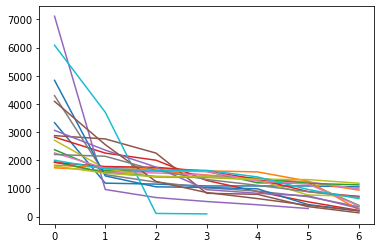

In [54]:
plt.figure()
for link in links:
    response = requests.get(link)
    im = Image.open(BytesIO(response.content))
    im = im.convert('RGB')
    im = im.resize((100, 100))
    ar = np.array(im)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    codes, dist = cluster.vq.kmeans(ar, NUM_CLUSTERS)
    vecs, dist = cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    sorted_counts = -np.sort(-counts)
    plt.plot(sorted_counts)

In [194]:
duckduckgo_search_urls(word,max_results=20)

['https://tse3.mm.bing.net/th?id=OIP.hcg-GLtlWVwxOKWF_IZ16wHaEo&pid=Api',
 'https://tse4.mm.bing.net/th?id=OIP.fjqXUxKeE6j5mbnWXuVzDwHaEo&pid=Api',
 'https://tse4.mm.bing.net/th?id=OIP.HA-nMfLgGbM5pbGtsteSFAHaEK&pid=Api',
 'https://tse3.mm.bing.net/th?id=OIP.rW2KgeCqUd9jU-MDjP0MEwHaE8&pid=Api',
 'https://tse3.mm.bing.net/th?id=OIP.7-o6sA-DjlfB0efn8j3LAwHaE8&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.ruHIJWIZvnQBH3dfX085XgHaEK&pid=Api',
 'https://tse1.mm.bing.net/th?id=OIP.JrOkyV_hSAdnPtvuiBX0HwHaEK&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.Hb22XwZN7aL8rfu4-dNskAHaEK&pid=Api',
 'https://tse4.mm.bing.net/th?id=OIP.ulrBgR3owNzjFp0nwDnfBQHaO0&pid=Api',
 'https://tse3.mm.bing.net/th?id=OIP.i0aJFZWWgPJMhH8lopcc7gHaEo&pid=Api',
 'https://tse1.mm.bing.net/th?id=OIP.F3Ip5PVrSn2yXX_gcssrXwHaFj&pid=Api',
 'https://tse4.mm.bing.net/th?id=OIP.Kcs3ZX5EQh-z5cSk9id2LQHaNK&pid=Api',
 'https://tse1.mm.bing.net/th?id=OIP.Ta4TRtIOtfrz67zSQl5GNAHaEK&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.w

In [198]:
links

['https://tse1.mm.bing.net/th?id=OIP.zglZ6CI-F7y3uTpS7R1JQQHaEo&pid=Api',
 'https://tse4.mm.bing.net/th?id=OIP.yXCk4Ll5ZOxKyc6h25uHGwHaEo&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.qXfUXYiDlTHqJFg4wFYb6QHaHa&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.79j4b925MuIhKK1txMI1jwHaFj&pid=Api',
 'https://tse3.mm.bing.net/th?id=OIP.wyLUZ8ianCbhgVdqATTpHAHaHa&pid=Api',
 'https://tse4.mm.bing.net/th?id=OIP.u_JW4HPacHHql8mIQyHzsgHaL2&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.aFIIkRoIKlgz2vM_oc-SKgHaJ4&pid=Api',
 'https://tse4.mm.bing.net/th?id=OIP.opw8S1AZPHg9I6J0mvbhOAHaE6&pid=Api',
 'https://tse1.mm.bing.net/th?id=OIP.qsvqoEPCkPuk878OpIrXhwHaEK&pid=Api',
 'https://tse3.mm.bing.net/th?id=OIP.7IsO8ggQFxtT66zVwfDm8QHaFQ&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.-ZG41LXjxUoJb61DRKS4ZgHaE8&pid=Api',
 'https://tse1.mm.bing.net/th?id=OIP.og1xssMlFoUQsnMtDJbeygHaE8&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.AQHcKlOvaCmiwTvXXFx7VAHaEK&pid=Api',
 'https://tse2.mm.bing.net/th?id=OIP.e

In [243]:
top_words = top_n_list('zh', 50000)  

In [233]:
def word_to_color(word):
    links = duckduckgo_search_urls(word)
    colors = []
    for link in links:
        try:
            response = requests.get(link)
            im = Image.open(BytesIO(response.content))
            im = im.convert('RGB')
            im = im.resize((100, 100))
            ar = np.array(im)
            shape = ar.shape
            ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)
            peak = median_centroid(ar,NUM_CLUSTERS=5)
            colors.append(peak)
        except:
            pass
    md = median_centroid(np.array(colors),NUM_CLUSTERS=3)
    color = binascii.hexlify(bytearray(int(c) for c in md)).decode('ascii')
    return color,np.trace(np.cov(np.stack(colors).T/255)**2)

In [234]:
a,b= word_to_color('apple')

In [238]:
print_color((('█████', '#'+a),))

0.02626121006538208

In [237]:
a,b= word_to_color('i')

In [199]:
word = 'grey'
links = duckduckgo_search_urls(word,max_results=20)
# plt.figure()
colors = []
for link in links:
    response = requests.get(link)
    im = Image.open(BytesIO(response.content))
    im = im.convert('RGB')
    im = im.resize((100, 100))
    ar = np.array(im)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

#     codes, dist = cluster.vq.kmeans(ar, NUM_CLUSTERS)
#     vecs, dist = cluster.vq.vq(ar, codes)         # assign codes
#     counts, bins = np.histogram(vecs, len(codes))    # count occurrences
#     sorted_counts = -np.sort(-counts)
#     color_code = codes[np.argmax(counts)]
    color_code = median_centroid(ar,NUM_CLUSTERS=5)
    colors.append(color_code/255)
#     print(color_code)
    color = binascii.hexlify(bytearray(int(c) for c in color_code)).decode('ascii')
    print_color((('█████', '#'+color),))
#     print(color)
#     plt.figure()
#     plt.plot(sorted_counts)
#     plt.figure()
#     plt.imshow(im)
print(np.trace(np.cov(np.stack(colors).T)**2))

0.005071131217370039


In [196]:
word = 'the'
links = duckduckgo_search_urls(word,max_results=20)
# plt.figure()
colors = []
for link in links:
    response = requests.get(link)
    im = Image.open(BytesIO(response.content))
    im = im.convert('RGB')
    im = im.resize((100, 100))
    ar = np.array(im)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

#     codes, dist = cluster.vq.kmeans(ar, NUM_CLUSTERS)
#     vecs, dist = cluster.vq.vq(ar, codes)         # assign codes
#     counts, bins = np.histogram(vecs, len(codes))    # count occurrences
#     sorted_counts = -np.sort(-counts)
#     color_code = codes[np.argmax(counts)]
    color_code = median_centroid(ar,NUM_CLUSTERS=5)
    colors.append(color_code/255)
#     print(color_code)
    color = binascii.hexlify(bytearray(int(c) for c in color_code)).decode('ascii')
    print_color((('█████', '#'+color),))
#     print(color)
#     plt.figure()
#     plt.plot(sorted_counts)
#     plt.figure()
#     plt.imshow(im)
print(np.trace(np.cov(np.stack(colors).T))**2)

0.020345891289790228


In [144]:
# print(np.cov(np.stack(colors).T))

[[ 0.05061145 -0.0028767   0.00272226]
 [-0.0028767   0.01588727  0.01926341]
 [ 0.00272226  0.01926341  0.03013343]]


In [162]:
# plt.figure()
word = 'the'
links = duckduckgo_search_urls(word,max_results=20)
colors = []
for link in links:
    response = requests.get(link)
    im = Image.open(BytesIO(response.content))
    im = im.convert('RGB')
    im = im.resize((100, 100))
    ar = np.array(im)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

#     codes, dist = cluster.vq.kmeans(ar, NUM_CLUSTERS)
#     vecs, dist = cluster.vq.vq(ar, codes)         # assign codes
#     counts, bins = np.histogram(vecs, len(codes))    # count occurrences
#     sorted_counts = -np.sort(-counts)
#     color_code = codes[np.argmax(counts)]
    color_code = median_centroid(ar,NUM_CLUSTERS=5)
    colors.append(color_code/255)
#     print(color_code)
    color = binascii.hexlify(bytearray(int(c) for c in color_code)).decode('ascii')
    print_color((('█████', '#'+color),))
#     print(color)
#     plt.figure()
#     plt.plot(sorted_counts)
#     plt.figure()
#     plt.imshow(im)
print(np.trace(np.cov(np.stack(colors).T)))
# print(np.cov(np.stack(colors).T)[0][0])

0.15493363700543952


In [146]:
print(np.cov(np.stack(colors).T))

[[0.05840811 0.03819615 0.01737669]
 [0.03819615 0.04218789 0.03765835]
 [0.01737669 0.03765835 0.05269846]]


In [138]:
print(np.cov(np.stack(colors).T)

SyntaxError: unexpected EOF while parsing (<ipython-input-138-8db73f3ed794>, line 1)

In [79]:
from termcolor import colored

In [89]:
from IPython.display import HTML as html_print
from IPython.display import display

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def print_color(t):
    display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in t])))

# print_color((('hello my name is', 'black'),('jhjfd','red')))
print_color((('█████', '#f6685e'),))

In [50]:
codes, dist = cluster.vq.kmeans(ar, NUM_CLUSTERS)
vecs, dist = cluster.vq.vq(ar, codes)         # assign codes
counts, bins = np.histogram(vecs, len(codes))    # count occurrences
sorted_counts = -np.sort(-counts)
plt.plot(sorted_counts)

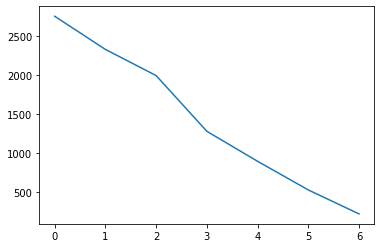

In [51]:
plt.plot(sorted_counts)

In [ ]:
links = duckduckgo_search_urls(word)
colors = []
for link in links:
    try:
        response = requests.get(link)
        im = Image.open(BytesIO(response.content))
#         color_thief = ColorThief(BytesIO(response.content))
#         peak = color_thief.get_color(quality=1)
        im = im.convert('RGB')
        im = im.resize((100, 100))
        ar = np.array(im)
        shape = ar.shape
        # if shape[-1]!=3:
        #     continue
        ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)
        peak = median_centroid(ar,NUM_CLUSTERS=5)

        colors.append(peak)
    except:
        pass
#     md = median_centroid(np.array(list(colors)).astype(float),NUM_CLUSTERS=3)
md = median_centroid(np.array(colors),NUM_CLUSTERS=3)
color = binascii.hexlify(bytearray(int(c) for c in md)).decode('ascii')

In [54]:
import json
import numpy as np
import matplotlib.pyplot as plt

def js_r(filename: str):
    with open(filename) as f_in:
        return json.load(f_in)
# cov_env = js_r('data_cov_en.json')

In [55]:
cov_env = js_r('data_cov_en.json')
missing_word = js_r('missing_words_en.json')
all_word_to_color = js_r('data_words_en.json')

In [56]:
for w in missing_word:
    cov_env[w] = 0 
    all_word_to_color[w] = "#000000"

In [57]:
cov_env_value = np.array(list(cov_env.values()))
keys = list(cov_env.keys())

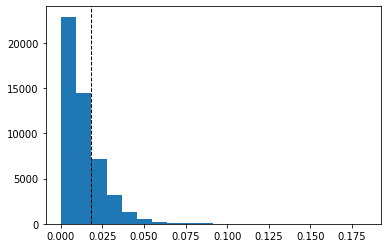

In [76]:
plt.hist(cov_env_value,bins=20)
# line = cov_env_value.mean()
threshhold = 0.018
plt.axvline(threshhold, color='k', linestyle='dashed', linewidth=1)

In [106]:
np.linspace(0,0.175)

array([0.        , 0.00357143, 0.00714286, 0.01071429, 0.01428571,
       0.01785714, 0.02142857, 0.025     , 0.02857143, 0.03214286,
       0.03571429, 0.03928571, 0.04285714, 0.04642857, 0.05      ,
       0.05357143, 0.05714286, 0.06071429, 0.06428571, 0.06785714,
       0.07142857, 0.075     , 0.07857143, 0.08214286, 0.08571429,
       0.08928571, 0.09285714, 0.09642857, 0.1       , 0.10357143,
       0.10714286, 0.11071429, 0.11428571, 0.11785714, 0.12142857,
       0.125     , 0.12857143, 0.13214286, 0.13571429, 0.13928571,
       0.14285714, 0.14642857, 0.15      , 0.15357143, 0.15714286,
       0.16071429, 0.16428571, 0.16785714, 0.17142857, 0.175     ])

In [145]:
len(cov_env_value)

49950

In [153]:
cov_env_value_sorted = np.sort(cov_env_value)

In [154]:
# 100
step_size = 500

In [155]:
threshold_range = []
i=0
while i<len(cov_env_value_sorted):
    threshold_range.append(cov_env_value_sorted[i])
    i+=step_size

In [ ]:
threshold_range

In [157]:
with open('thresholds.json', 'w') as fp:
    json.dump(threshold_range, fp)

In [158]:
len(threshold_range)

100

In [77]:
# threshhold = np.mean(cov_env_value)
mask = cov_env_value>threshhold

In [91]:
with open('data.json', 'w') as fp:
    json.dump(all_word_to_color, fp)

In [97]:
for w in cov_env.keys():
    cov_env[w] = round(cov_env[w],5)

In [98]:
with open('data_cov.json', 'w') as fp:
    json.dump(cov_env, fp)

In [80]:
all_word_mask = {}
for i,key in enumerate(keys):
    all_word_mask[key] = mask[i]

In [81]:
cov_env['i']

0.02244570463434601

In [ ]:
all_word_mask